In [2]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.regularizers import l1

np.random.seed(1337) # for reproducibility
vocab = ["A", "G", "C", "T"]
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)
table = tf.lookup.StaticVocabularyTable(table_init, 1)
defs = [0.] * 1 + [tf.constant([], dtype = "string")]

# Nadav dataset

def data_reader(file, batch_size=100, n_parse_threads = 4):
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset=dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])
    chars_indeces = table.lookup(chars)
    X = tf.one_hot(chars_indeces, depth = len(vocab))
    Y = fields[0]
    return X,Y


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data in three partitions
file="/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv"
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

df_train, df_test = train_test_split(whole_data, test_size=0.2, random_state=42)
df_validation, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

df_train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_train.csv", index=False)
df_test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_test.csv", index=False)
df_validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_validation.csv", index=False)


In [ ]:
input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_train.csv"
input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_validation.csv"
input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_test.csv"

corr_list = []
df_repetition = pd.DataFrame()

for i in range(0,10):
    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(file):
        input_shape = element[0].shape

    inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
    layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
    layer = BatchNormalization()(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(0.3)(layer)
    layer = Flatten()(layer)
    layer = Dense(300, activation='sigmoid')(layer)  # 300
    layer = Dropout(0.3)(layer)
    layer = Dense(200, activation='sigmoid')(layer)  # 300
    predictions = Dense(1, activation='linear')(layer)

    model = Model(inputs=inputs, outputs=predictions)
    model.summary()

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse", "mae", "mape"],
                )

    history=model.fit(data_reader(input_path_train, batch_size=100),
                            epochs=20,
                            validation_data=data_reader(file,batch_size=100),
                            callbacks=None,
                            verbose=1)

    predicted = model.predict(data_reader(input_path_test,
                                                batch_size=100))

    test_data = data_reader(input_path_test,batch_size=100)
    test_tensor = X = np.empty(shape=[0,1])
    for batch in test_data:
        test_tensor = np.append(test_tensor, batch[1])

    import math
    def pearson_correlation(x, y):
        n = len(x)
        # Calculate the mean of x and y
        mean_x = sum(x) / n
        mean_y = sum(y) / n
        
        # Calculate the numerator and denominators of the correlation coefficient
        numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
        denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
        denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
        
        # Calculate the correlation coefficient
        correlation = numerator / (denominator_x * denominator_y)
        return correlation
        
    corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
    corr_list.append(corr_coefficient)
    df_repetition[str(i)] =predicted.flatten()

In [ ]:
df_copy = df_repetition
df_repetition["col_mean"] = df_repetition.mean(axis = 1)
print(pearson_correlation(df_repetition.col_mean, test_tensor))
print(df_repetition.corr().abs())
df_repetition


In [ ]:

corr_list

In [ ]:
#df_test["prediction"] = predicted
#df_test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_test_predicte.csv", index=False)


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data in three partitions
file="/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ.csv"
whole_data = pd.read_csv(file)

df_train, df_test = train_test_split(whole_data, test_size=0.2, random_state=42)
df_validation, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

df_train[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_train.csv", index=False)
df_test[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_test.csv", index=False)
df_validation[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_validation.csv", index=False)

In [ ]:

input_path_train = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_train.csv"
input_path_test = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_test.csv"
input_path_valid = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_validation.csv"

# Get first item of the dataset to get the shape of the input data
for element in data_reader(input_path_train):
    input_shape = element[0].shape

inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.5)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.5)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.5)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.5)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mse", "mae", "mape"],
              )

history=model.fit(data_reader(input_path_train, batch_size=100),
                        epochs=15,
                        validation_data=data_reader(input_path_valid,batch_size=100),
                        callbacks=None,
                        verbose=1)

predicted = model.predict(data_reader(input_path_test,
                                            batch_size=100))

test_data = data_reader(input_path_test,batch_size=100)
test_tensor = X = np.empty(shape=[0,1])
for batch in test_data:
    test_tensor = np.append(test_tensor, batch[1])

import math
def pearson_correlation(x, y):
    n = len(x)
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation
    
corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)

In [ ]:
print("Correlation: "+str(corr_coefficient))
print("Test Data : \n"+str(test_tensor[:10]))
print("Predictions :\n" +str(predicted[:10]))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    
create_plots(history)

In [ ]:
#Read Data
import shap
_dataset = data_reader("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv", batch_size=10000)
shuffled_dataset = _dataset.shuffle(5000)
iterator = shuffled_dataset.as_numpy_iterator()
random_sample = next(iterator)
X = random_sample[0]

rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
explainer = shap.DeepExplainer((model.inputs, model.layers[-1].output), X[rn])
explainer.shap_values(X[0:10], ranked_outputs=1)

#shap_values_top, indexes = explainer.shap_values(X, ranked_outputs=1)

In [ ]:
#Read Data
import shap
_dataset = data_reader("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv", batch_size=10000)
shuffled_dataset = _dataset.shuffle(5000)
iterator = shuffled_dataset.as_numpy_iterator()
random_sample = next(iterator)
X = random_sample[0]

In [ ]:
print(X.shape)
rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
X[rn].shape

In [ ]:
rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 200, replace=False)
rn

In [ ]:
def one_hot_to_dna_sequence(one_hot_sequence, vocab):
    """
    Convert a one-hot-encoded DNA sequence back to a DNA sequence using the provided vocabulary.
    Args:
    - one_hot_sequence: A tensor containing the one-hot-encoded DNA sequence.
    - vocab: A list of vocabulary characters (e.g., ["A", "G", "C", "T"]).

    Returns:
    - dna_sequence: A tensor containing the decoded DNA sequence.
    """
    # Get the index of the maximum value along the one-hot encoding axis
    decoded_indices = tf.argmax(one_hot_sequence, axis=-1)

    # Use the indices to map back to DNA characters
    dna_sequence = tf.gather(vocab, decoded_indices)

    return dna_sequence

In [ ]:
whole_data

In [3]:
# CROSS VALIDATION
from sklearn.model_selection import train_test_split, KFold

# Split the data in three partitions
file="/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv"
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2008)
result = next(kf.split(whole_data), None)

o=1
for i in kf.split(whole_data):
    train = whole_data.iloc[i[0]]
    test =  whole_data.iloc[i[1]]
    
    train, validation = train_test_split(whole_data, test_size=0.10, random_state=42)
    
    train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1
        

In [4]:
df_test_overall  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
print(df_test_overall)
corr_list = []

for i in range(1,11):
    
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
    df_test = pd.read_csv(input_path_test)

    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape

    inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
    layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
    layer = BatchNormalization()(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(0.3)(layer)
    layer = Flatten()(layer)
    layer = Dense(300, activation='sigmoid')(layer)  # 300
    layer = Dropout(0.3)(layer)
    layer = Dense(200, activation='sigmoid')(layer)  # 300
    predictions = Dense(1, activation='linear')(layer)

    model = Model(inputs=inputs, outputs=predictions)
    model.summary()

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse", "mae", "mape"],
                )

    history=model.fit(data_reader(input_path_train, batch_size=100),
                            epochs=20,
                            validation_data=data_reader(input_path_valid,batch_size=100),
                            callbacks=None,
                            verbose=1)

    predicted = model.predict(data_reader(input_path_test,
                                                batch_size=100))

    test_data = data_reader(input_path_test,batch_size=100)
    test_tensor = X = np.empty(shape=[0,1])
    for batch in test_data:
        test_tensor = np.append(test_tensor, batch[1])

    df_test["prediction"] = predicted
    df_test["fold"] = str(i)
    df_test_overall = df_test_overall.append(df_test, ignore_index=True)

    
    def pearson_correlation(x, y):
        n = len(x)
        # Calculate the mean of x and y
        mean_x = sum(x) / n
        mean_y = sum(y) / n
        
        # Calculate the numerator and denominators of the correlation coefficient
        numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
        denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
        denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
        
        # Calculate the correlation coefficient
        correlation = numerator / (denominator_x * denominator_y)
        return correlation
        
    corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
    corr_list.append(corr_coefficient)

df_test_overall.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold.csv", index=False)

Empty DataFrame
Columns: [State_3E, seq, prediction]
Index: []
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout (Dropout)           (None, 256, 250)          0         
                                                                 
 batch_normalization (Batch  (None, 256, 250)          1000      
 Normalization)                                                  
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_1 (Bat  (None, 249, 250)          1000     

2023-10-17 15:26:49.597694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-17 15:26:49.639767: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-17 15:26:49.741324: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-17 15:26:51.129318: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca64918ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 15:26:51.129349: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-17 15:26:51.133924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 15:26:51.259724: I ./tensorflow/compiler/jit/device_comp

77/77 [==============================] - 8s 32ms/step - loss: 0.0859 - mse: 0.0859 - mae: 0.2041 - mape: 55690.4688 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0954 - val_mape: 316.1502
Epoch 2/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.1110 - mape: 6295.9746 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0966 - val_mape: 352.6797
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0942 - mape: 3703.2922 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1021 - val_mape: 464.9964
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0843 - mape: 6587.1001 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1041 - val_mape: 496.8221
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0780 - mape: 1347.6101 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1078 - val_mape: 551.0288


/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_5 (Dropout)         (None, 256, 250)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 256, 250)          1000      
 chNormalization)                                                
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_5 (Bat  (None, 249, 250)          1000      
 chNormalization)                                          

/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_10 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_8 (Bat  (None, 256, 250)          1000      
 chNormalization)                                                
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_9 (Bat  (None, 249, 250)          1000      
 chNormalization)                                          

2023-10-17 15:28:43.959299: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902
/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_15 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_12 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_13 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-17 15:28:49.748144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902


77/77 [==============================] - 2s 21ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1080 - mape: 5450.2437 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1003 - val_mape: 433.9836
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0932 - mape: 5356.9043 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.0999 - val_mape: 425.0341
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0825 - mape: 5745.3501 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.1007 - val_mape: 441.8535
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0757 - mape: 5231.7603 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1150 - val_mape: 640.6551
Epoch 6/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0730 - mape: 10414.4951 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1313 - val_mape: 809.8181


/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_20 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_16 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_17 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-17 15:29:27.958231: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902


77/77 [==============================] - 2s 21ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1005 - mape: 1320.6792 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0980 - val_mape: 385.5536
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0829 - mape: 4298.9624 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1055 - val_mape: 517.7083
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0772 - mape: 10337.1709 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1224 - val_mape: 722.1279
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0769 - mape: 18475.6699 - val_loss: 0.0273 - val_mse: 0.0273 - val_mae: 0.1363 - val_mape: 853.2267
Epoch 6/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0716 - mape: 6223.1860 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1266 - val_mape: 767.4125

2023-10-17 15:30:00.426929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902
/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_25 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_20 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_21 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-17 15:30:06.026739: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 27961498287980307
2023-10-17 15:30:06.026819: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902


77/77 [==============================] - 2s 21ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0973 - mape: 7190.2021 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0952 - val_mape: 309.9921
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0851 - mape: 3857.9216 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0960 - val_mape: 336.1583
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0820 - mape: 10908.1299 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0965 - val_mape: 349.1705
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0762 - mape: 15216.4521 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1135 - val_mape: 623.7964
Epoch 6/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0717 - mape: 6200.3906 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1328 - val_mape: 824.8154

2023-10-17 15:30:38.418199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902
/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_30 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_24 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_25 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-17 15:30:43.552833: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 27961498287980307
2023-10-17 15:30:43.552907: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902


77/77 [==============================] - 4s 25ms/step - loss: 0.0929 - mse: 0.0929 - mae: 0.2101 - mape: 28736.5117 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.0936 - val_mape: 177.5007
Epoch 2/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1108 - mape: 3852.4370 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.0961 - val_mape: 100.7330
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0944 - mape: 9915.1729 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.0962 - val_mape: 101.0092
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0843 - mape: 11076.9248 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0987 - val_mape: 142.6039
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0773 - mape: 7047.1631 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.0937 - val_mape: 164.0666

/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_35 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_28 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_29 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-17 15:31:22.180267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902


77/77 [==============================] - 5s 24ms/step - loss: 0.0390 - mse: 0.0390 - mae: 0.1491 - mape: 15839.9404 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1014 - val_mape: 453.6438
Epoch 2/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.0969 - mape: 12169.5146 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0959 - val_mape: 332.6686
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0842 - mape: 2411.1704 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.0999 - val_mape: 424.9244
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0808 - mape: 14273.0771 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0936 - val_mape: 222.6135
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0799 - mape: 2329.1594 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1041 - val_mape: 497.439

2023-10-17 15:31:55.231983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902
/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_40 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_32 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_33 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_45 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_36 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_37 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-17 15:33:11.557796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5422068039076722902
/tmp/ipykernel_718338/2433276998.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_overall = df_test_overall.append(df_test, ignore_index=True)


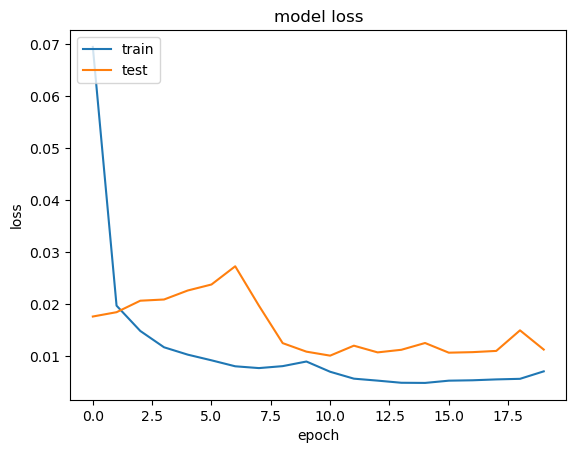

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    
create_plots(history)

In [6]:
df_test_overall.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold.csv", index=False)
df_test_overall

,State_3E,seq,prediction,fold
0,-0.007714,AGGACCGGATCAACTAAACAACTCAAACAAGGGCTAATATAACCCA...,-0.066135,1
1,0.137953,AGGACCGGATCAACTAAACACTAGTCATACTTAAAAATTGCAAGGA...,0.010291,1
2,-0.048706,AGGACCGGATCAACTAAACAGGTTCTGACGTATGCTCCTCTATGGA...,-0.075280,1
3,-0.052804,AGGACCGGATCAACTAAACCCGAGCCTGCCTAGCCCTAGCTTCTCT...,-0.063390,1
4,0.213652,AGGACCGGATCAACTAAACGGAGCAGAGTTAGTGTCAGGTCAAAAA...,0.164081,1
...,...,...,...,...
8473,0.167100,AGGACCGGATCAACTTTTCCGCCTTTTATTATCAGGACTTCACGGG...,0.259291,10
8474,0.099489,AGGACCGGATCAACTTTTCGCTCATTAGTACAGGGTATAACGGAAG...,0.028705,10
8475,-0.046939,AGGACCGGATCAACTTTTGGTCGGTTGACGGTCGCCTTGATTATTC...,-0.024755,10
8476,0.093662,AGGACCGGATCAACTTTTTTATCTGGTTATCATTCTAGTCTAGTGC...,0.038336,10


In [ ]:
corr_list

In [ ]:
df_test_overall  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])

    
input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV1_LibA_wide_pivot_state3_train.csv"
input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV1_LibA_wide_pivot_state3_validation.csv"
input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV1_LibA_wide_pivot_state3_test.csv"
df_test = pd.read_csv(input_path_test)

# Get first item of the dataset to get the shape of the input data
for element in data_reader(input_path_train):
    input_shape = element[0].shape

inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.3)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.3)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer="adam",
            loss="mean_squared_error",
            metrics=["mse", "mae", "mape"],
            )

history=model.fit(data_reader(input_path_train, batch_size=100),
                        epochs=20,
                        validation_data=data_reader(input_path_valid,batch_size=100),
                        callbacks=None,
                        verbose=1)

predicted = model.predict(data_reader(input_path_test,
                                            batch_size=100))

test_data = data_reader(input_path_test,batch_size=100)
test_tensor = X = np.empty(shape=[0,1])
for batch in test_data:
    test_tensor = np.append(test_tensor, batch[1])

df_test["prediction"] = predicted
df_test_overall = df_test_overall.append(df_test, ignore_index=True)


def pearson_correlation(x, y):
    n = len(x)
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation
    
corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)


In [ ]:
df_test

In [ ]:
df_test

In [ ]:
# CROSS VALIDATION
from sklearn.model_selection import train_test_split, KFold

# Split the data in three partitions
whole_data=pd.read_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ.csv")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2008)
result = next(kf.split(whole_data), None)

o=1
for i in kf.split(whole_data):
    train = whole_data.iloc[i[0]]
    test =  whole_data.iloc[i[1]]
    
    train, validation = train_test_split(whole_data, test_size=0.10, random_state=42)
    
    train[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/CV"+str(o)+"_mean_with_sequence_ENCFF616IAQ_train.csv", index=False)
    test[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/CV"+str(o)+"_mean_with_sequence_ENCFF616IAQ_test.csv", index=False)
    validation[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/CV"+str(o)+"_mean_with_sequence_ENCFF616IAQ_validation.csv", index=False)
    o+=1
        

In [ ]:
df_test_overall  = pd.DataFrame(columns=["meanVal", "Sequence"])
print(df_test_overall)
corr_list = []

for i in range(1,10):
    
    input_path_train = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/CV"+str(i)+"_mean_with_sequence_ENCFF616IAQ_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/CV"+str(i)+"_mean_with_sequence_ENCFF616IAQ_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/CV"+str(i)+"_mean_with_sequence_ENCFF616IAQ_test.csv"
   
    df_test = pd.read_csv(input_path_test)

    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape

    inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
    layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
    layer = BatchNormalization()(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(0.3)(layer)
    layer = Flatten()(layer)
    layer = Dense(300, activation='sigmoid')(layer)  # 300
    layer = Dropout(0.3)(layer)
    layer = Dense(200, activation='sigmoid')(layer)  # 300
    predictions = Dense(1, activation='linear')(layer)

    model = Model(inputs=inputs, outputs=predictions)
    model.summary()

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse", "mae", "mape"],
                )

    history=model.fit(data_reader(input_path_train, batch_size=1024),
                            epochs=20,
                            validation_data=data_reader(input_path_valid,batch_size=100),
                            callbacks=None,
                            verbose=1)

    predicted = model.predict(data_reader(input_path_test,
                                                batch_size=100))

    test_data = data_reader(input_path_test,batch_size=100)
    test_tensor = X = np.empty(shape=[0,1])
    for batch in test_data:
        test_tensor = np.append(test_tensor, batch[1])

    df_test["prediction"] = predicted
    df_test["fold"] = str(i)
    df_test_overall = df_test_overall.append(df_test, ignore_index=True)
    
    def pearson_correlation(x, y):
        n = len(x)
        # Calculate the mean of x and y
        mean_x = sum(x) / n
        mean_y = sum(y) / n
        
        # Calculate the numerator and denominators of the correlation coefficient
        numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
        denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
        denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
        
        # Calculate the correlation coefficient
        correlation = numerator / (denominator_x * denominator_y)
        return correlation
        
    corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
    corr_list.append(corr_coefficient)

df_test_overall.to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/10fold_cv/mean_with_sequence_ENCFF616IAQ_test_predicted_cv10fold.csv", index=False)